In [1]:
from __future__ import print_function

import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
import copy
import time
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import utils

In [2]:
input_list = ['MMM', 'T', 'ABBV', 'ABT', 'ACN', 'AGN', 'ALL', 'GOOGL', 
              'GOOG', 'MO', 'AMZN', 'AXP', 'AIG', 'AMGN', 'AAPL', 'BAC', 'BIIB', 
              'BLK', 'BA', 'BMY', 'CVS', 'COF', 'CAT', 'CELG', 'CVX', 'CSCO', 'C', 
              'KO', 'CL', 'CMCSA', 'COP', 'COST', 'DHR', 'DOW', 'DUK', 'DD', 'EMC', 
              'EMR', 'EXC', 'XOM', 'FB', 'FDX', 'F', 'GD', 'GE', 'GM', 'GILD', 'GS', 'HAL', 
              'HD', 'HON', 'INTC', 'IBM', 'JPM', 'JNJ', 'KMI', 'LLY', 'LMT', 'LOW', 'MA', 
              'MCD', 'MDT', 'MRK', 'MET', 'MSFT', 'MDLZ', 'MON', 'MS', 'NKE', 'OXY', 
              'ORCL', 'PEP', 'PFE', 'PM', 'PG', 'QCOM', 'RTN', 'SLB', 'SPG', 'SO', 'SBUX', 
              'TGT', 'TXN', 'BK', 'PCLN', 'TWX', 'FOXA', 'FOX', 'USB', 'UNP', 'UPS', 'UTX', 
              'UNH', 'VZ', 'V', 'WMT', 'WBA', 'DIS', 'WFC']

In [3]:
print ("Started!!")

st = time.time()
start_date="2015-04-01"
end_date="2016-04-01"
input_data, input_list = utils.get_fixed_data(input_list, start_date=start_date, end_date=end_date) 
elapsed = time.time() - st
print ("time for getting data:", elapsed)

Started!!
('fail_name_list: ', [])
time for getting data: 182.635243893


In [4]:
print (input_data.values.shape)

(253, 99)


In [5]:
print(input_data.index)

DatetimeIndex(['2015-04-01', '2015-04-02', '2015-04-06', '2015-04-07',
               '2015-04-08', '2015-04-09', '2015-04-10', '2015-04-13',
               '2015-04-14', '2015-04-15',
               ...
               '2016-03-18', '2016-03-21', '2016-03-22', '2016-03-23',
               '2016-03-24', '2016-03-28', '2016-03-29', '2016-03-30',
               '2016-03-31', '2016-04-01'],
              dtype='datetime64[ns]', length=253, freq=None)


# DDPG for trading


Given data, you are going to learn how to manage your portfolio.

In [6]:
# import numpy as np 
# input_data = np.zeros((505, 99))
n_stock = len(input_data.values[0])

class MultiDDPGConfig(object):
    activation = 'relu'
    gamma = 0.95
    history_length = 10
    n_stock = n_stock
    n_smooth = 3
    n_down = 3
    k_w = 3
    n_hidden = 100
    n_batch = 32
    n_epochs = 100
    n_feature = 5
    update_rate = 0.5
    learning_rate = 1e-3

In [7]:
from model import DDPG
import warnings
warnings.filterwarnings("ignore")

config = MultiDDPGConfig()

dqn = DDPG(config)
print ("start!")
values = dqn.train(input_data)
print ("finished!")

Using TensorFlow backend.


building model....
finished building model!
start!
training....


UnboundLocalError: local variable 'reward' referenced before assignment

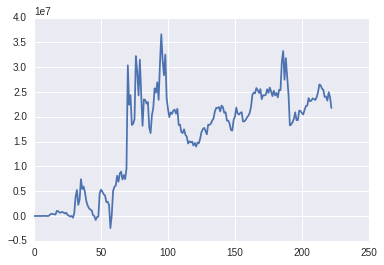

In [52]:
plt.plot(values)

In [53]:
date_label = input_data.index

In [60]:
date_label[0]

Timestamp('2015-04-01 00:00:00')

In [57]:
date_list = list(date_label)

In [59]:
pd.DatetimeIndex(date_list)

DatetimeIndex(['2015-04-01', '2015-04-02', '2015-04-06', '2015-04-07',
               '2015-04-08', '2015-04-09', '2015-04-10', '2015-04-13',
               '2015-04-14', '2015-04-15',
               ...
               '2016-03-18', '2016-03-21', '2016-03-22', '2016-03-23',
               '2016-03-24', '2016-03-28', '2016-03-29', '2016-03-30',
               '2016-03-31', '2016-04-01'],
              dtype='datetime64[ns]', length=253, freq=None)